# Day 1: Introduction and Simplicial complexes
Welcome to our topological data analysis discussion session. The goal of these sessions are for you to get hands on and familiar with different TDA tools and techniques. Today, the idea is for you to play with some point cloud data and image data and get familiar with the concepts from lecture as well as popular Python TDA packages (Gudhi for today's notebook). 

*Note*: Before you run this notebook, please make sure you have followed all installation directions for python, conda, and the various packages you will need throughout this week in the README.md

In [2]:
# all imports here
import numpy as np
import gudhi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
from sklearn import datasets
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay


# Triangulations and meshes

First, we will look at a simplicial complex which is generated from a triangulation. 

In [3]:
def triangulate_sphere(ax, k=30, cmap=cm.magma):
    ''' Creates a triangulation of a sphere 

    Parameters: 
        ax: matplotlib ax object to draw the triangulation
        k: determines how fine the triangulation should be
        cmap: color map for drawing

    Returns:
        list of triangles so that triangles[i, :] are the indices
        of the points making up the ith triangle
    '''

    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    S1 = np.cos(X) * np.sin(Y)
    S2 = np.sin(X) * np.sin(Y)
    S3 = np.cos(Y)

    tri = Delaunay(np.array([X.flatten(), Y.flatten()]).T)
    
    ax.plot_trisurf(
        S1.flatten(), S2.flatten(), S3.flatten(),
        triangles=tri.simplices, cmap=cmap
    )

    return tri.simplices

In [4]:
def sphere_simplex(k=30, cmap=cm.magma):
    ''' Creates a triangulation simplex of a sphere 

    Parameters: 
        k: determines how fine the triangulation should be
        cmap: color map for drawing

    Returns:
        simplex of vertices
    '''

    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    S1 = np.cos(X) * np.sin(Y)
    S2 = np.sin(X) * np.sin(Y)
    S3 = np.cos(Y)

    tri = Delaunay(np.array([X.flatten(), Y.flatten()]).T)
    
    # ax.plot_trisurf(
    #     S1.flatten(), S2.flatten(), S3.flatten(),
    #     triangles=tri.simplices, cmap=cmap
    # )

    return tri

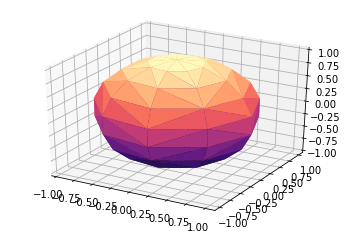

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
triangles = triangulate_sphere(ax, k=10)
plt.show()

In [6]:
# TODO: Compute the Euler characteristic of the simplicial complex generated by the triangulation of the sphere

## Point Cloud Data

In this section, we will generate Rips complexes for various 2D and 3D point clouds. I've already provided a couple functions for loading point cloud data and visualizing simplicial complexes with matplotlib. 

In [7]:
def load_pcd(filename, show=False):
    ''' Loads 2D/3D point cloud data from *.npy files

    Parameters:
        filename: name of *.npy file.
        show: option to visualize point clouds in 3D

    Returns: 
        np.array formatted as [point_1, point_2, ..., point_n]
    
    '''
    array = np.load(filename)
    dim = array.shape[1]
    if show:
        fig = plt.figure()
        if dim == 3:
            ax = fig.add_subplot(projection='3d')
            ax.set_xlim3d(-1, 1)
            ax.set_ylim3d(-1, 1)
            ax.set_zlim3d(-1, 1)
            ax.scatter(array[:, 0],array[:, 1], array[:, 2])
        else:
            ax = fig.add_subplot()
            ax.scatter(array[:, 0], array[:, 1])
    return array 

In [8]:
def complex_visualizer_PCD(points, complex, ax, animation=False):
    ''' Visualizes complex generated from 2D or 3D point cloud data.

    Parameters:
        points: original point cloud data
        complex: simplicial complex formatted as [simplex_1, simplex_2, .... simplex_nn]. 
        Each simplex_i is a list of indices.

    '''
    dim = points.shape[1]

    for filtered_value in complex.get_filtration():
        if filtered_value[1] == 0.0:
            continue
        indices = filtered_value[0]
        sdim = len(indices) - 1
        if sdim > 1:
            alpha=0.4
        else:
            alpha = 1.0
        splex_verts = points[indices]
        color = [(1 - 1/sdim)*0.5, (1 - 1/sdim)*0.5, (1 - 1/sdim)]
        if dim == 2:
            ax.fill(splex_verts[:, 0], splex_verts[:, 1], c=color, alpha=alpha)
        else:
            verts = splex_verts.tolist()
            ax.add_collection3d(Poly3DCollection([verts], color=color, alpha=alpha))
    if animation:
        assert dim == 2
        container = ax.get_children()
        return container
    return ax

In [9]:
def animate_2d(points, min_radius, max_radius, name='animation.gif'):
    ''' Animates Rips complex at different radii. 

    Parameters:
        points: original point cloud data
        min_radius: minimum radius
        max_radius: maximum radius
    '''
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=(0.0, 0.0, 0.0))
    artists = []
    for i in range(min_radius, max_radius):
        cplex = rips_gudhi(points, i)
        container = complex_visualizer_PCD(points, cplex, ax, animation=True)
        artists.append(container)
    ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=100)
    ani.save(name)

In [10]:
def rips_gudhi(points, radius, max_dimension=2, show=False):
    ''' TODO: use Gudhi to create a Rips complex of some fixed radius parameter. 

    Parameters:
        points: original point cloud data
        radius: radius parameter
        max_dimension: maximum dimension of simplices in resulting complex
        show: option to visualize complex 

    Returns:
        Gudhi SimplexTree object

    '''

    # Create a Rips complex object
    rips_complex = gudhi.RipsComplex(points=points,max_edge_length=radius)

    # Create a simplex tree object using the Rips complex
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)

    return simplex_tree


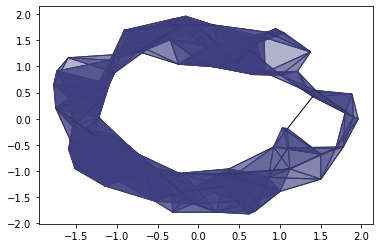

In [11]:
# TODO: Load each of the 2D point clouds and compute the Rips complex for each dataset at various radii
#       Visualize each Rips complex you generate with `complex_visualizer_PCD`.
#       Finally, create an animation of the Rips complex at different radii for at least one of the 2D point clouds using `animate_2D` 

data = load_pcd("C:/Users/Will/Documents/GitHub/msri-ml-week1/data/sam/msri-data/point-clouds/2D/annulus.npy", show=False)

simplex = rips_gudhi(data,0.7,show=True)

fig = plt.figure()
ax = fig.add_subplot()

complex_visualizer_PCD(data, simplex, ax)



In [1]:
# TODO: Load each of the 3D point clouds and compute the Rips complex for each dataset at various radii.
#       Visualize each Rips complex you generate with `complex_visualizer_PCD`.

# data = load_pcd("C:/Users/Will/Documents/GitHub/msri-ml-week1/data/sam/msri-data/point-clouds/3D/airplane.npy", show=False)

# simplex = rips_gudhi(data,0.7,show=True)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# complex_visualizer_PCD(data, simplex, ax)

In [13]:
# data = load_pcd("data/sam/msri-data/point-clouds/3D/airplane.npy")

# animate_2d(data,1,2)

### Extra: implement Rips complex computation

In [14]:
def rips_implementation(points, radius, max_dimension=2):
    ''' TODO: Create your own implementation of the Rips complex from point cloud data. 
        One way to do this is to create a distance matrix, create a neighborhood graph based on edges
        less than your desired radius, and then check for k-cliques where k < max_dimension + 1. 
        Verify the correctness of your complex against the Gudhi implementation.

    Parameters:
        points: original point cloud data
        radius: radius parameter
        max_dimension: maximum dimension of simplices in resulting complex
        show: option to visualize complex 

    Returns:
        List of simplices that make up your Rips Complex. 
    '''
    raise NotImplementedError('Please implement')

## Image Data

In this section, we will read various sample images (from sklearn sample datasets) and compute sublevel sets for images. 

In [15]:
def load_sample_flower():
    images = datasets.load_sample_images()
    return images.images[1]

def load_sample_temple():
    images = datasets.load_sample_images()
    return images.images[0]

def load_mnist_images():
    digits = datasets.load_digits()
    return digits.images

In [16]:
def compute_sublevel_set(image, threshhold):
    ''' TODO: Given an image, compute a sublevel set given a certain threshhold

    Parameters:
        image: image as a numpy array of pixel values
        threshhold: threshhold value 

    Returns:
        numpy array of pixel values in sublevel set
    '''
    raise NotImplementedError('Please implement and delete this line')

In [17]:
# TODO: Choose an image from the MNIST dataset and compute the sublevel sets at several different threshholds
#       If you have time, create an animation of sublevel sets using matplotlib or whichever library you would like. 
#       Note that some of the images will be full color - make sure to convert these to greyscale images. 